In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb

# データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。

今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。

(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [3]:
# データの前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [4]:
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

In [5]:
# One-Hot-encoding
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_o = enc.fit_transform(y_train[:, np.newaxis])
y_test_o = enc.fit_transform(y_test[:, np.newaxis])
print(y_train.shape)
print(y_train_o.shape)

(60000,)
(60000, 10)


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_o, test_size=0.2)
print(X_train.shape)
print(X_val.shape)

(48000, 1, 28, 28)
(12000, 1, 28, 28)


# 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。

In [7]:
# np.padメモ
# 第1引数にはN次元の配列、第2引数には前・後の文字詰め量、第3引数には埋め込み方式を指定します。
#第3引数のmodeは色々指定ができて、edgeだと両端の値をコピーします。

#constant 標準
#edge 端の値をコピー
#linear_ramp 直線傾斜になる様に端を補完
#maximum 最大値で補完
#mean 平均値で補完
#median 中央値で補完
#minimum 最小値で補完
#reflect 反射して補完 - ABCBABCBA の様になる
#symmetric 対称な補完 - ABCCBAABC の様になる
#wrap 順序を模して補完
#empty 1.17以降使用可能

data = [1,2,3]
np.pad(data, [2,3], 'constant')

array([0, 0, 1, 2, 3, 0, 0, 0])

In [8]:
# test用のデータ
X = np.random.rand(1, 1, 28, 28)
W = np.array([[[[1, 1, 1],
                         [2, 1, 1],
                         [1, 2, 1]]]])
b = np.array([1])
W.shape

(1, 1, 3, 3)

## im2colで実装

In [9]:
class Conv2d_im2col:
    """
    
    """
    def __init__(self, w, b, stride=1, padding=0):
        self.w = w
        self.b = b
        self.stride = stride
        self.pad = padding
        
    # im２col利用したforward関数
    def im2col_foward(self, X):
        """
        ２次元畳み込みフォアードの関数
        ---------------
        parameter
        ---------------
        X: 入力データ
        N: 入力データの個数
        H: 入力データの高さ
        W:入力データの幅
        i :　配列行方向インデックス
        j:　配列列方向のインデックス
        m:　出力チャネルのインデックス
        C:　入力チャネル数
        FN: フィルタのこすう
        FH:　フィルタの高さ
        FW:　フィルタの幅
        FC:　フィルタのチャネル
        W: フィルタ
        b：　バイアス
        """ 
        self.X = X
        
        #各データのチャネル、高さ、幅の取り出し
        self.N ,self.C, self.H, self.W = X.shape
        self.FN, self.FC, self.FH, self.FW = self.w.shape
        OH, OW = self.N_out_size(X, self.w,  self.pad, self.stride)

        # im2col(x, FH, FW, stride, padding)
        self.col = self.im2col(self.X, self.FH, self.FW, self.stride, self.pad)
        self.col_w = self.w.reshape(self.FN, -1).T
        out = np.dot(self.col, self.col_w) + self.b
        out = out.reshape(self.N, OH, OW, -1).transpose(0, 3, 1, 2)
        
        return out
        
    # backward関数
    def backward(self, n_out):
        """
        ２次元畳み込みバックプロバゲーションの関数
        ---------------
        parameter
        ---------------
        n_out:　入力データ

        ---------------
        return
        ---------------
        dx: デルタX値
        """
        n_out = n_out.transpose(0, 2, 3, 1).reshape(-1, self.FN)

        self.db = np.sum(n_out, axis=0)
        self.dw = np.dot(self.col.T, n_out)
        self.dw = self.dw.transpose(1, 0).reshape(self.FN, self.FC, self.FH, self.FW)

        dcol = np.dot(n_out, self.col_w.T)
        self.dx = self._col2im(dcol, self.X.shape, self.FH, self.FW, self.stride, self.pad)
        self.w, self.b = self.update()
        return self.dx
    
    # update関数
    def update(self):
        """
        フィルタとバイアス更新式
        ----------------
        parameter
        ----------------
        lr: 学習率
        w：フィルタ
        b：バイアス
        ---------------
        return
        ---------------
        w ： 更新後のW 
        b ：　更新後のb
        """
        self.w = self.w  - self.lr * self.dw
        self.b = self.b -self. lr * self.db

        return  self.w, self.b 
        
    # im2col関数
    def im2col(self, input_data, FH, FW, stride, pad):
        N, C, H, W = input_data.shape
        #出力データのサイズ
        out_h = (H + 2*pad - FH)//stride + 1
        out_w = (W + 2*pad - FW)//stride + 1

        # paddingの追加
        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        # データの空箱作成
        col = np.zeros((N, C, FH, FW, out_h, out_w))

        for y in range(FH):
            y_max = y + stride*out_h
            for x in range(FW):
                x_max = x + stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        return col  
    
    def N_out_size(self,N, F, P, S):
        """
        出力データのサイズを導く関数
        -------------------
        parameter
        -------------------
        N:　入力データ
        Nh：入力データの高さ
        Nw：　入力データの幅
        F：　filter
        Fh：フィルタの高さ
        Fw：　フィルタの幅
        P：　パディング
        S: ストライド
        Sh：ストライドの高さ方向
        Sw：ストライドの幅方向
        ------------------
        return
        ------------------
        Nh_out：出力データの高さ
        Nw_out：　出力データの幅
        """
        _, _, NH, NW = N.shape
        _, _, FH , FW = F.shape

        NH_out = (NH + 2*P - FH) // S +1
        NW_out = (NW + 2*P - FW) // S +1 
        return NH_out,  NW_out

In [10]:
C2im = Conv2d_im2col(W, b)

In [11]:
out = C2im.im2col_foward(X)
out.shape

(1, 1, 26, 26)

In [12]:
# Maxpool2D_im2col._foward(out)
# C2im.backward(out)

# im2col

In [13]:
# im2col を利用するとドット演算できるようなので調査
def im2col(input_data, FH, FW, stride=1, pad=0):
    N, C, H, W = input_data.shape
    #出力データのサイズ
    out_h = (H + 2*pad - FH)//stride + 1
    out_w = (W + 2*pad - FW)//stride + 1

    # paddingの追加
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    # データの空箱作成
    col = np.zeros((N, C, FH, FW, out_h, out_w))

    for y in range(FH):
        y_max = y + stride*out_h
        for x in range(FW):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col   

In [14]:
# im２col利用したforward関数
def im2col_foward(X, w, b):
    """
    ２次元畳み込みフォアードの関数
    ---------------
    parameter
    ---------------
    X: 入力データ
    N: 入力データの個数
    H: 入力データの高さ
    W:入力データの幅
    i :　配列行方向インデックス
    j:　配列列方向のインデックス
    m:　出力チャネルのインデックス
    C:　入力チャネル数
    FN: フィルタのこすう
    FH:　フィルタの高さ
    FW:　フィルタの幅
    FC:　フィルタのチャネル
    W: フィルタ
    b：　バイアス
    """ 
    #各データのチャネル、高さ、幅の取り出し
    N ,C, H, W = X.shape
    FN, FC, FH, FW = w.shape
    
    # im2col(x, FH, FW, stride, padding)
    col = im2col(X, FH, FW)
    col_w = w.reshape(FN, -1).T
    
    out = np.dot(col, col_w) + b
    out = out.reshape(1, -1)
    return out

In [15]:
#col2im
def col2im(col, input_shape, FH, FW, stride=1, pad=0):
    N, C, H, W = input_shape
    #出力データのサイズ
    out_h = (H + 2*pad - FH)//stride + 1
    out_w = (W + 2*pad - FW)//stride + 1
    col = col.reshape(N, out_h, out_w, C, FH, FW).transpose(0, 3, 4, 5, 1, 2)
    
    img = np.zeros((N, C, H + 2*pad + stride -1, W+ 2*pad+stride-1))
    for y in range(FH):
        y_max = y + stride * out_h
        for x in range(FW):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [16]:
def col2im(col, input_size, FH, FW, stride, pad):
    N, C, H, W = input_size
    out_h = (H + 2*padding - FH) // stride - 1
    out_w = (H + 2*padding - FW) // stride -1
    col = col.reshape(N, C, out_h, out_w, FH, FW).transpose(0,3, 4, 5, 1, 2)
    
    img = np.zeros([N, C, H+ stride-1, W+stride-1])
    for h in range(FH):
        # maxの値を
        h_max = h + out_h 
        for w in range(Fw):
            w_max = w + out_w 
            img[:, :, h:h_max, w:w_max] += col[:, :, h, w, :, :]
    return img

In [17]:
# update関数
def _update():
    """
    フィルタとバイアス更新式
    ----------------
    parameter
    ----------------
    lr: 学習率
    w：フィルタ
    b：バイアス
    ---------------
    return
    ---------------
    w ： 更新後のW 
    b ：　更新後のb
    """
    self.W = self.W  - lr * self.dw
    self.b = self.b - lr * self.db
    
    return  self.W, self.b 

In [18]:
loss = np.random.rand(1, 2, 2, 2)
print(loss)
W = np.random.rand(2, 1, 3, 3)
print(W)

[[[[0.76662006 0.906587  ]
   [0.95781739 0.58750533]]

  [[0.42946182 0.55416201]
   [0.97974356 0.89638276]]]]
[[[[0.80527476 0.5682331  0.12909379]
   [0.25695728 0.94534857 0.08472914]
   [0.14287944 0.9860277  0.48300623]]]


 [[[0.18681795 0.00492776 0.80054377]
   [0.03945274 0.37170842 0.19255396]
   [0.28988465 0.4109351  0.21510424]]]]


# 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

In [19]:
def N_out_size(N, W, P, S):
    """
    出力データのサイズを導く関数
    -------------------
    parameter
    -------------------
    N:　入力データ
    Nh：入力データの高さ
    Nw：　入力データの幅
    F：　フィルタ
    Fh：フィルタの高さ
    Fw：　フィルタの幅
    P：　パディング
    Sh：ストライドの高さ方向
    Sw：ストライドの幅方向
    ------------------
    return
    ------------------
    Nh_out：出力データの高さ
    Nw_out：　出力データの幅
    """
    _, _, NH, NW = N.shape
    _, _, FH , FW = W.shape

    NH_out = (NH + 2*P - FH) // S +1
    NW_out = (NW + 2*P - FW) // S +1 
    return NH_out,  NW_out

In [20]:
N_out_size(X, W, 0, 1)

(26, 26)

# 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

In [21]:
# im2col版
class Maxpool2D_im2col:
    def __init__(self, pool_size=(2,2), stride=1, padding=0):
        self.PH,  self.PW = pool_size
        self.stride = stride
        self.pad = padding
        
    def _forward(self, X):
        """
        parameter
        --------------
        N：入力データのこすう
        C：入力データのチャネル数
        H：入力データの高さ
        W：入力データの幅
        
        return
        --------------
        out : maxpooling
        
        """
        self.X_shape = X.shape
        self.N, self.C, self.H, self.W = self.X_shape
        out_h = (self.H + 2*self.pad - self.PH) // self.stride + 1
        out_w = (self.W + 2*self.pad - self.PW)// self.stride + 1
        col = im2col(X, self.PH, self.PW, self.stride, self.pad)
        col = col.reshape(-1, self.PH*self.PW)
        
        
        index_max = np.argmax(col, axis=1)
#         print(index_max.shape)
#         #index_max = index_max.reshape(-1, self.PH*self.PW)
#         index_max = index_max.reshape(self.N, self.C, self.H-1, self.W-1)
#         print(index_max.shape)
        out = np.max(col, axis=1)
        out = out.reshape(self.N, out_h, out_w, self.C).transpose(0, 3, 1, 2)
        self.index_max = index_max
        return out 
    
    def _backward(self, n_out):
        """
        """
        n_out = n_out.transpose(0, 2, 3, 1)
        
        pool_size = self.PH * self.PW
        out_max = np.zeros((n_out.size, pool_size))
        out_max[np.arange(self.index_max.size), self.index_max.flatten()] = n_out.flatten()
        out_max = out_max.reshape(n_out.shape + (pool_size,))
        
        dcol = out_max.reshape(out_max.shape[0] * out_max.shape[1] * out_max.shape[2], -1)
        dx = col2im(dcol, self.X_shape, self.PH, self.PW, self.stride, self.pad)
        
        return dx

In [22]:
MX2D = Maxpool2D_im2col((2, 2), 1, 0)

In [23]:
# pool_f = MX2D._forward(out)
# # flattenしたデータ
# # pool_b = MX2D._backward(pool_f)
# # pool_b.shape

In [24]:
class Maxpool2D:
    def __init_(self, pool_size=(2,2), stride=1, padding=0):
        self.PH,  self.PW = pool_size
        self.stride = stride
        self.pad = padding
        
    def _forward(n_out):
        """
        """
        N, C, H, W = n_out.shape
        out_h = (H + 2*pad - PH)//stride + 1
        out_w = (W + 2*pad - PW)//stride + 1
        
        for n in range(N):
            for c in range(C):
                for i in  range(H // PH):
                    for j in range(W // PW):
                        n_out[n, c, i: i + PH, j:j+PW]

# 【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。


範囲内の最大値ではなく、平均値を出力とするプーリング層です。


画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

# 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [25]:
class Flatten:
    """
    平滑化クラス    
    """
    def forward(self, x):
        """
        Parameters
        ----------
        x : 入力データ
        
        Returns
        ----------
        a : 出力データ
        
        """
        # 出力チャンネル数と画像サイズに該当する次元を減らす
        self.x_shape = x.shape
        
        z = z.reshape(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        
        return z
    
    def backward(self, da):
        """
        Parameters
        ----------
        da : 後ろから流れてきた勾配
        
        Returns
        ----------
        dz : 前に流す勾配
        
        """
        # プーリング層へ流すために、forward時の元の次元数に戻す
        dz = da.reshape(self.x_shape)
        
        return dz

# 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。


精度は低くともまずは動くことを目指してください。

In [26]:
# バッチの用意
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=10):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [40]:
# スクラッチのCNN
class CNN_scratch:
    """
    n_iter :学習回数
    lr: 学習率
    sigma:初期値
    batch:バッチサイズ
    loss:lossの保管
    val_loss:バリデーションのloss保管
    filter_output:アウトプットの値
    filter_channel:フィルタのチャネル数
    filter_size:フィルタのサイズ
    """
    def __init__(self, lr=0.01,sigma=0.1, n_iter=3, batch=20, filter_output=30, filter_channel=1, filter_size=3, vervose=False):
        # 　学習回数
        self.iter = n_iter
        self.lr = lr
        self.sigma = sigma
        self.batch = batch
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        self.filter_output = filter_output
        self.filter_channel = filter_channel
        self.filter_size = filter_size
        
    
    def fit(self, X, y,  X_val=None, y_val=None):
        self.n_features = X.shape[0]
        self.n_output = 10
        # 入力用のデータ
        input_size = 28
        padding = 0
        stride = 1
        filter_num = 30
        conv_output_size = (input_size - self.filter_size + 2 * padding) / stride + 1
        pool_output_size = int(self.filter_output * (conv_output_size / 2) * (conv_output_size / 2))


        #更新方法の定義
        self.optimizer = AdaGrad(self.lr, self.batch)
        #　畳み込み層の定義
        self.Conv2d = Conv2d_im2col(FN=30, FC=1, FH=3, FW=3, lr = self.lr)
        # １層目出力データの活性化の定義
        self.Conv_activation = Relu()
        # pooling処理の定義
        self.Pool = Maxpool2D_im2col()
        #　平滑化処理の定義
        self.flatten = Flatten()
        # 全結合層の定義
        self.FC1 = FC(18750, self.n_output, HeInitializer(self.filter_output), self.optimizer)

        # 最終層の活性化の定義
        self.activation1 = Softmax()

        # 学習開始
        for i in range(self.iter):
            #  バッチサイズのカウント
            count = 0
            history = np.zeros(X.shape[0] // self.batch)
            val_history = np.zeros(X_val.shape[0] // self.batch)
            #　ミニバッチの取り出しコード
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch)
            for mini_X_train, mini_y_train in get_mini_batch:
                # forward
                A0 = self.Conv2d.forward(mini_X_train)#畳み込み層
                Z0 = self.Conv_activation.forward(A0)#RELUで活性化
                P0 = self.Pool.forward(Z0)#pooling 
                F0 = self.flatten.forward(P0)#flattenして平滑化
                A1 = self.FC1.forward(F0)#全結合層
                Z1 = self.activation1.forward(A1)#Softmaxで活性化

                # backward
                dA1, history[count] = self.activation1.backward(Z1, mini_y_train)#Softmaxのバック
                #flatten元の形に戻す
                dZ1 = self.FC1.backward(dA1)#全結合層のバック
                #flatten元の形に戻す
                dF0 = self.flatten.backward(dZ1)
                #pooling層のバック
                dP0 = self.Pool.backward(dF0)
                dA0 = self.Conv_activation.backward(dP0)#RELUのバック
                dZ0 = self.Conv2d.backward(dA0)#畳み込み層のバック
                count += 1
            
            #loss保管のため学習したパラメータでforward
            A0 = self.Conv2d.forward(X)#畳み込み層
            Z0 = self.Conv_activation.forward(A0)#RELUで活性化
            P0 = self.Pool.forward(Z0)#pooling 
            F0 = self.flatten.forward(P0)#flattenして平滑化
            A1 = self.FC1.forward(F0)#全結合層
            Z1 = self.activation1.forward(A1)#Softmaxで活性化
            
            _, history= self.activation1.backward(Z1, y)
            self.loss[i] = history
            
            # X_valあった場合の処理
            if np.any(X_val): 
                A0 = self.Conv2d.forward(X_val)
                Z0 = self.Conv_activation.forward(A0)
                P0 = self.Pool.forward(Z0)#pooling 
                F0 = self.flatten.forward(P0)#flattenして平滑化
                A1 = self.FC1.forward(F0)
                Z1 = self.activation1.forward(A1)
                # 学習記録
                _, val_history = self.activation1.backward(Z1, y_val)
                self.val_loss[i] = val_history
            
            
    # 推定
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        print(X.shape)
        A0 = self.Conv2d.forward(X)#畳み込み層
        Z0 = self.Conv_activation.forward(A0)#RELUで活性化
        P0 = self.Pool.forward(Z0)#pooling 
        F0 = self.flatten.forward(P0)#flattenして平滑化
        A1 = self.FC1.forward(F0)#全結合層
        Z1 = self.activation1.forward(A1)#Softmaxで活性化
        return np.argmax(Z1, axis= 1)
    
    
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.w = initializer.W(self.n_nodes1, self.n_nodes2)
        self.b =  initializer.B(self.n_nodes2)
        # adagrad用
        #if Adagrad = True: 
        self.h_w = np.zeros((n_nodes1, n_nodes2))
        self.h_b = np.zeros(n_nodes2)

    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """     
        self.Z = X
        
        self.A =  (X @ self.w) + self.b
        return self.A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.db = np.sum(dA, axis=0)
        self.dw = self.Z.T @ dA 
        dZ = dA @ self.w.T
        # 更新
        self = self.optimizer.update(self)
        return dZ    

    
#初期化
class HeInitializer():
    
    def __init__(self, sigma):
        self.sigma = np.sqrt(2 / sigma)
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :　重みの初期値
        """
        self.w = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return self.w
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :　バイアスの初期値
        """
        self.b = self.sigma * np.random.randn(n_nodes2)
        return self.b

    
# 活性化関数
class Softmax():
    def forward(self, A):
        # overflow対策
        A_max = np.max(A, axis=1)
        exp_A = np.exp(A - A_max.reshape(-1, 1))
        sum_exp_A = np.sum(exp_A, axis=1).reshape(-1, 1)
        return exp_A / sum_exp_A
    
    def backward(self, Z, Y):
        loss = self._cross_entropy(Z, Y)
        D  = Z - Y
        return D, loss 
    
    def _cross_entropy(self,Z, y):
        """
        パラメータ
        ーーーーーーーーーーーーー
        y : 正解ラベル（one-hot表現）
        z３　：　クラスの確率
        n : バッチサイズ

        """
        if y.ndim == 1:    # 次元が 1 の場合
            y = y.reshape(1, y.size)
        batch_size = y.shape[0]
        return -1* np.sum(y * np.log(Z)) / batch_size


# 活性化関数
class Relu():
    def forward(self, A):
        self.mask = (A <= 0)
        a = A.copy()
        self.A = A
        a[self.mask] = 0
        return np.maximum(0, A)
      
    def backward(self, dA):
        dA[self.mask] = 0
        out = dA
        return out

    
# AdaGrad
class AdaGrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr, batch):
        self.lr = lr
        self.batch = batch
        # 過去の勾配の２乗和の保管用
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.h_w += (layer.dw/ self.batch) * (layer.dw/ self.batch)
        layer.h_b += (layer.db/self.batch) * (layer.db / self.batch)
        layer.w -= self.lr * (1 / (np.sqrt(layer.h_w) + 1e-07)) * (layer.dw/ self.batch)
        layer.b -= self.lr * (1 / (np.sqrt(layer.h_b) + 1e-07)) * (layer.db/ self.batch)
        
#         layer.h_W += layer.dW * layer.dW
#         layer.h_B += layer.dB * layer.dB
#         layer.W -= self.lr * (1 / (np.sqrt(layer.h_W) + 1e-07)) * layer.dW
#         layer.B -= self.lr * (1 / (np.sqrt(layer.h_B) + 1e-07)) * layer.dB
        return layer
                                 
    
#　畳み込み層  
class Conv2d_im2col:
    """
    
    """
    def __init__(self, FN, FC, FH, FW, lr, stride=1, padding=0, sigma=0.01):
        self.FN = FN
        self.FC = FC
        self.FH = FH
        self.FW = FW
        self.lr = lr
        self.stride = stride
        self.pad = padding
        self.w = sigma * np.random.randn(self.FN, self.FC, self.FH, self.FW)
        self.b = np.zeros(self.FN)
        
    # im２col利用したforward関数
    def forward(self, X):
        """
        ２次元畳み込みフォアードの関数
        ---------------
        parameter
        ---------------
        X: 入力データ
        N: 入力データの個数
        H: 入力データの高さ
        W:入力データの幅
        i :　配列行方向インデックス
        j:　配列列方向のインデックス
        m:　出力チャネルのインデックス
        C:　入力チャネル数
        FN: フィルタのこすう
        FH:　フィルタの高さ
        FW:　フィルタの幅
        FC:　フィルタのチャネル
        W: フィルタ
        b：　バイアス
        """ 
        self.X = X
        
        #各データのチャネル、高さ、幅の取り出し
        self.N ,self.C, self.H, self.W = X.shape
        self.FN, self.FC, self.FH, self.FW = self.w.shape
        OH, OW = self.N_out_size(X, self.w,  self.pad, self.stride)

        # im2col(x, FH, FW, stride, padding)
        self.col = self.im2col(self.X, self.FH, self.FW, self.stride, self.pad)
        self.col_w = self.w.reshape(self.FN, -1).T
        out = np.dot(self.col, self.col_w) + self.b
        out = out.reshape(self.N, OH, OW, -1).transpose(0, 3, 1, 2)
        return out
        
    # backward関数
    def backward(self, n_out):
        """
        ２次元畳み込みバックプロバゲーションの関数
        ---------------
        parameter
        ---------------
        n_out:　入力データ

        ---------------
        return
        ---------------
        dx: デルタX値
        """
        n_out = n_out.transpose(0, 2, 3, 1).reshape(-1, self.FN)

        self.db = np.sum(n_out, axis=0)
        self.dw = np.dot(self.col.T, n_out)
        self.dw = self.dw.transpose(1, 0).reshape(self.FN, self.FC, self.FH, self.FW)

        dcol = np.dot(n_out, self.col_w.T)
        self.dx = self.col2im(dcol, self.X.shape, self.FH, self.FW, self.stride, self.pad)
        self.w, self.b = self._update()
        return self.dx
    
    # update関数
    def _update(self):
        """
        フィルタとバイアス更新式
        ----------------
        parameter
        ----------------
        lr: 学習率
        w：フィルタ
        b：バイアス
        ---------------
        return
        ---------------
        w ： 更新後のW 
        b ：　更新後のb
        """
        self.w = self.w  - self.lr * self.dw
        self.b = self.b -self. lr * self.db

        return  self.w, self.b 
    
    def N_out_size(self,N, F, P, S):
        """
        出力データのサイズを導く関数
        -------------------
        parameter
        -------------------
        N:　入力データ
        Nh：入力データの高さ
        Nw：　入力データの幅
        F：　filter
        Fh：フィルタの高さ
        Fw：　フィルタの幅
        P：　パディング
        S: ストライド
        Sh：ストライドの高さ方向
        Sw：ストライドの幅方向
        ------------------
        return
        ------------------
        Nh_out：出力データの高さ
        Nw_out：　出力データの幅
        """
        _, _, NH, NW = N.shape
        _, _, FH , FW = F.shape

        NH_out = (NH + 2*P - FH) // S +1
        NW_out = (NW + 2*P - FW) // S +1 
        return NH_out,  NW_out
        
    # im2col関数
    def im2col(self, input_data, FH, FW, stride, pad):
        N, C, H, W = input_data.shape
        #出力データのサイズ
        out_h = (H + 2*pad - FH)//stride + 1
        out_w = (W + 2*pad - FW)//stride + 1

        # paddingの追加
        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        # データの空箱作成
        col = np.zeros((N, C, FH, FW, out_h, out_w))

        for y in range(FH):
            y_max = y + stride*out_h
            for x in range(FW):
                x_max = x + stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        return col      

    #col2im
    def col2im(self,col, input_shape, FH, FW, stride=1, pad=0):
        N, C, H, W = input_shape
        #出力データのサイズ
        out_h = (H + 2*pad - FH)//stride + 1
        out_w = (W + 2*pad - FW)//stride + 1
        col = col.reshape(N, out_h, out_w, C, FH, FW).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*pad + stride -1, W+ 2*pad+stride-1))
        for y in range(FH):
            y_max = y + stride * out_h
            for x in range(FW):
                x_max = x + stride * out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, pad:H + pad, pad:W + pad]
    
    
# im2col版Maxpooling
class Maxpool2D_im2col:
    def __init__(self, pool_size=(2,2), stride=1, padding=0):
        self.PH,  self.PW = pool_size
        self.stride = stride
        self.pad = padding
        
    def forward(self, X):
        """
        parameter
        --------------
        N：入力データのこすう
        C：入力データのチャネル数
        H：入力データの高さ
        W：入力データの幅
        
        return
        --------------
        out : maxpooling
        
        """
        self.X_shape = X.shape
        self.N, self.C, self.H, self.W = self.X_shape
        out_h = (self.H + 2*self.pad - self.PH) // self.stride + 1
        out_w = (self.W + 2*self.pad - self.PW)// self.stride + 1
        col = self.im2col(X, self.PH, self.PW, self.stride, self.pad)
        col = col.reshape(-1, self.PH*self.PW)
        
        
        index_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(self.N, out_h, out_w, self.C).transpose(0, 3, 1, 2)
        self.index_max = index_max
        return out 
    
    def backward(self, n_out):
        """
        """
        n_out = n_out.transpose(0, 2, 3, 1)
        
        pool_size = self.PH * self.PW
        out_max = np.zeros((n_out.size, pool_size))
        out_max[np.arange(self.index_max.size), self.index_max.flatten()] = n_out.flatten()
        out_max = out_max.reshape(n_out.shape + (pool_size,))
        
        dcol = out_max.reshape(out_max.shape[0] * out_max.shape[1] * out_max.shape[2], -1)
        dx = self.col2im(dcol, self.X_shape, self.PH, self.PW, self.stride, self.pad)
        
        return dx
    
    # im2col関数
    def im2col(self, input_data, FH, FW, stride, pad):
        N, C, H, W = input_data.shape
        #出力データのサイズ
        out_h = (H + 2*pad - FH)//stride + 1
        out_w = (W + 2*pad - FW)//stride + 1

        # paddingの追加
        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        # データの空箱作成
        col = np.zeros((N, C, FH, FW, out_h, out_w))

        for y in range(FH):
            y_max = y + stride*out_h
            for x in range(FW):
                x_max = x + stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        return col  
    
    #col2im
    def col2im(self, col, input_shape, FH, FW, stride=1, pad=0):
        N, C, H, W = input_shape
        #出力データのサイズ
        out_h = (H + 2*pad - FH)//stride + 1
        out_w = (W + 2*pad - FW)//stride + 1
        col = col.reshape(N, out_h, out_w, C, FH, FW).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*pad + stride -1, W+ 2*pad+stride-1))
        for y in range(FH):
            y_max = y + stride * out_h
            for x in range(FW):
                x_max = x + stride * out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, pad:H + pad, pad:W + pad]
    
    
# 平滑化   
class Flatten:
    """
    平滑化クラス    
    """
    def forward(self, x):
        """
        Parameters
        ----------
        x : 入力データ
        
        Returns
        ----------
        a : 出力データ
        
        """
        # 出力チャンネル数と画像サイズに該当する次元を減らす
        self.x_shape = x.shape
        
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        
        return x
    
    def backward(self, da):
        """
        Parameters
        ----------
        da : 後ろから流れてきた勾配
        
        Returns
        ----------
        dz : 前に流す勾配
        
        """
        # プーリング層へ流すために、forward時の元の次元数に戻す
        dz = da.reshape(self.x_shape)
        
        return dz

In [41]:
CNN = CNN_scratch()

In [42]:
CNN.fit(X_train, y_train, X_val, y_val)

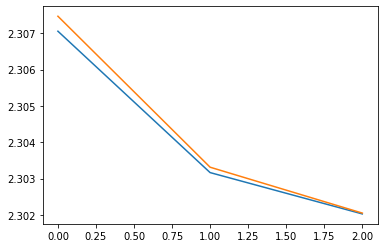

In [43]:
plt.plot(CNN.loss)
plt.plot(CNN.val_loss)
plt.show();

In [46]:
from sklearn.metrics import accuracy_score
y_pred = CNN.predict(X_test)
accuracy_score(y_test, y_pred)

(10000, 1, 28, 28)


0.1135

In [47]:
#精度は全く良くないがLossは減少している。